In [1]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import tensorflow as tf
from src.pricing.asset_price_process import GBM
from src.pricing.option_price_process import BSM
from src.custom_environments.HedgeEnv import env_hedging
from torch import nn


In [2]:
mu = 0
dt = 1/5
T = 10
num_steps = int(T/dt)
s_0 = float(100)
strike_price = s_0
sigma = 0.01
r = 0

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)


env = env_hedging(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 0, tick_size=0.1,
                     L=1, strike_price=strike_price, integer_holdings=True, initial_holding=0, mode="PL", shares_per_contract=100,
                  option_price_model=opm)



In [ ]:
stock_prices = []
option_prices = []
apm.reset()
for n in range(num_steps):
    current_stock_price = apm.get_current_price()
    stock_prices.append(current_stock_price)

    current_option_price = opm.compute_option_price(n, current_stock_price)
    option_prices.append(current_option_price)
    apm.compute_next_price()

time_axis = np.linspace(0, num_steps, num_steps)
plt.figure(figsize=(12, 8))
plt.plot(time_axis, stock_prices, label='Stock', color='green', linestyle='-')
# plt.plot(time_axis, option_prices, label='Option', color='red', linestyle='--')

In [25]:
from stable_baselines3 import PPO
from gym import spaces
from typing import Callable, Tuple
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

class DuPPONetwork(nn.Module):
    def __init__(self, feature_dim:int, last_layer_dim_pi : int =128, 
                 last_layer_dim_vf: int =128):
        super().__init__()

        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        layers = []
        layer_size = 128
        for _ in range(5):  # 5 hidden layers
            layers.append(nn.Linear(feature_dim, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            feature_dim = layer_size  # Update input dim for the next layer
        

        self.policy_net = nn.Sequential(*layers)
        self.value_net = nn.Sequential(*layers)

    def forward(self, features: th.Tensor)-> Tuple[th.Tensor, th.Tensor]:
        return self.forward_actor(features), self.forward_critic(features)
    
    def forward_actor(self, features: th.Tensor)-> th.Tensor:
        return self.policy_net(features)
    
    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)

class DuActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self, observation_space: spaces.Box,
        action_space: spaces.Discrete,
        lr_schedule: Callable[[float], float],
        *args, 
        **kwargs
    ):
        kwargs["ortho_init"]= True
        super().__init__(observation_space, action_space, lr_schedule, *args, **kwargs)
    
    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = DuPPONetwork(self.features_dim)


n_envs = 10
vec_env = make_vec_env(lambda:env_hedging(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 0, tick_size=0.1,
                     L=1, strike_price=strike_price, integer_holdings=True, initial_holding=0, mode="PL", shares_per_contract=100,
                  option_price_model=opm), n_envs= n_envs)

# vec_env = VecNormalize(vec_env, norm_reward=True)

# vec_env.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/models/PPO/du/PPO_23/vec_normalize_stats.pkl", vec_env)
    
custom_objects = {"policy_class": DuActorCriticPolicy}
model =PPO.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/src/drl_agents/models/PPO/du/PPO_38/ppo_100000", custom_objects= custom_objects)




In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import DQNPolicy
from torch.nn import functional as F
import os 


class DuMLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(DuMLP, self).__init__()
        
        # Define a sequence of layers: Linear -> BatchNorm -> ReLU
        layers = []
        layer_size = 128
        for _ in range(5):  # 5 hidden layers
            layers.append(nn.Linear(input_dim, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            input_dim = layer_size  # Update input dim for the next layer
        
        # Output layer to match the action space dimension
        layers.append(nn.Linear(layer_size, output_dim))
        
        # Wrap layers in a Sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.model(x)
    
    def set_training_mode(self, mode: bool):
        """Sets training mode to control batch normalization layers."""
        if mode:
            self.train()
        else:
            self.eval()


class DuDQNPolicy(DQNPolicy):
    def __init__(self, observation_space , action_space,
                  lr_schedule, **kwargs):
        super(DuDQNPolicy, self).__init__(observation_space, action_space, lr_schedule, **kwargs)
        
        # Create the custom feature extractor (MLP with batch norm and ReLU)
        input_dim = observation_space.shape[0]
        output_dim = action_space.n
        self.q_net = DuMLP(input_dim, output_dim)
        self.q_net_target = DuMLP(input_dim, output_dim)
        self.q_net_target.load_state_dict(self.q_net.state_dict())
        self.q_net_target.eval()

        # Set up optimizer for the Q-network
        self.optimizer = th.optim.Adam(self.q_net.parameters(), lr=1e-4)
    
    def forward(self, x: th.Tensor, deterministic : bool = True) -> th.Tensor:
        return self.q_net(x)
    
    def _predict(self, obs: th.Tensor, deterministic: bool = True) -> th.Tensor:
            q_values = self.q_net(obs)
            actions = q_values.argmax(dim=1).unsqueeze(-1)
            return actions

    def update_target_network(self):
        self.q_net_target.load_state_dict(self.q_net.state_dict())
    
    def set_training_mode(self, mode: bool):
        self.q_net.set_training_mode(mode)
        self.q_net_target.set_training_mode(mode)

custom_objects = {"policy_class": DuDQNPolicy}
model = DQN.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/models/DQN/du/DQN_7/dqn_2250000", custom_objects= custom_objects)

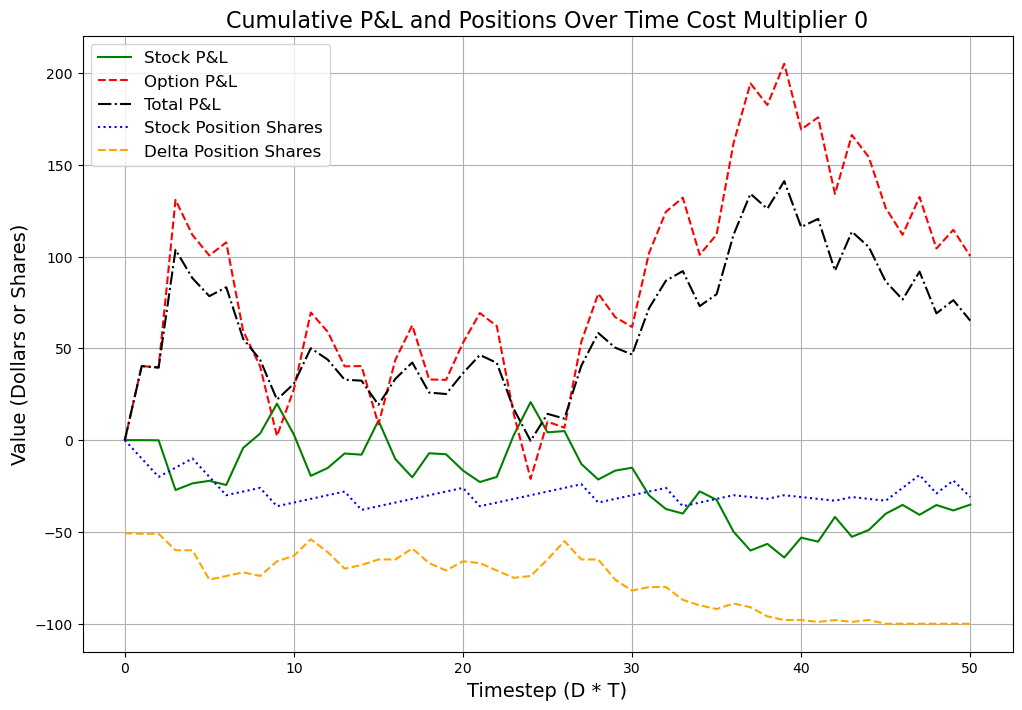

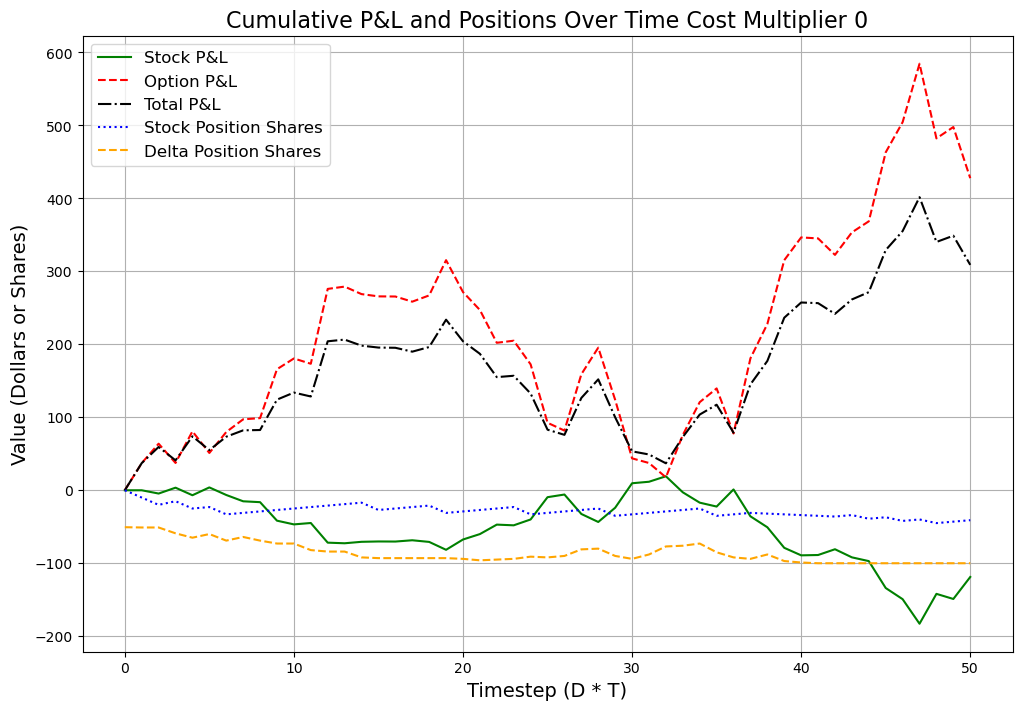

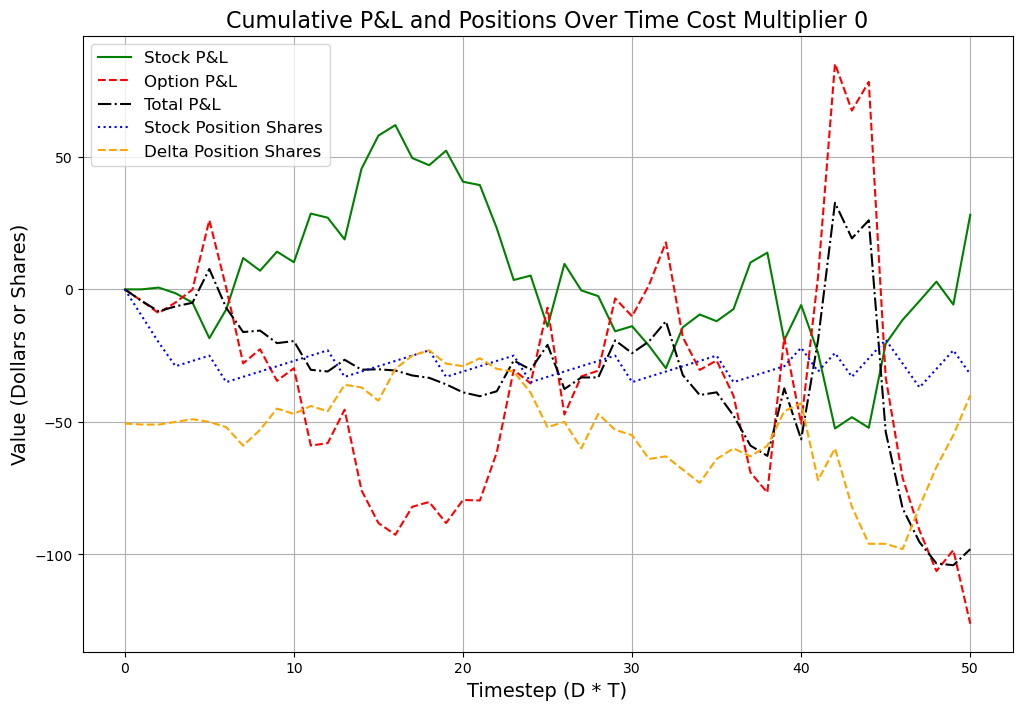

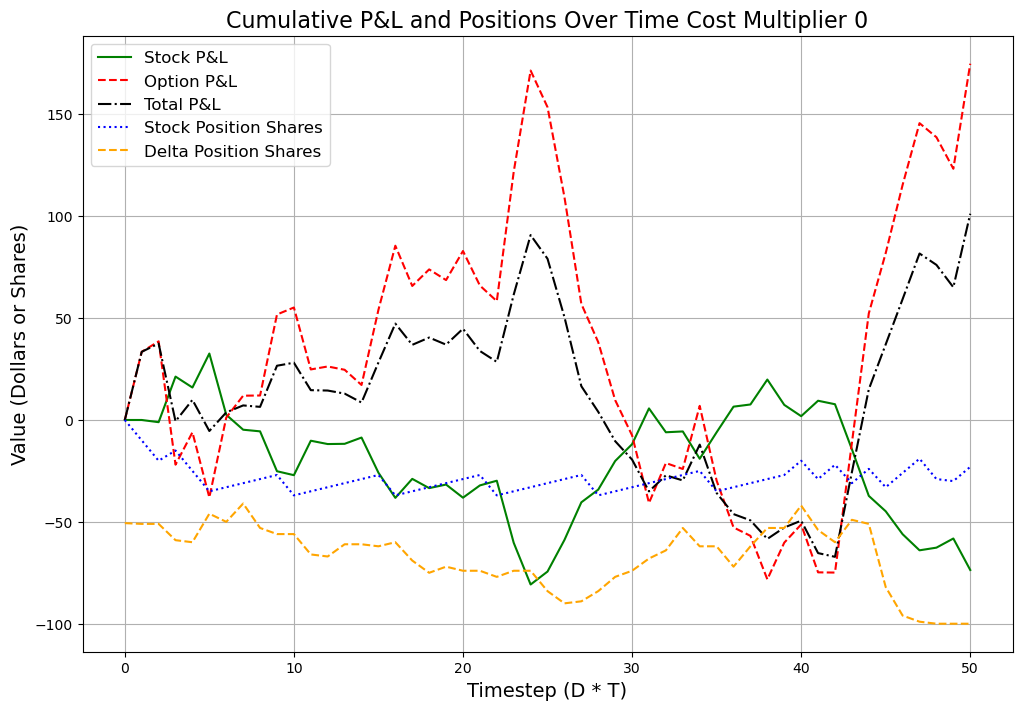

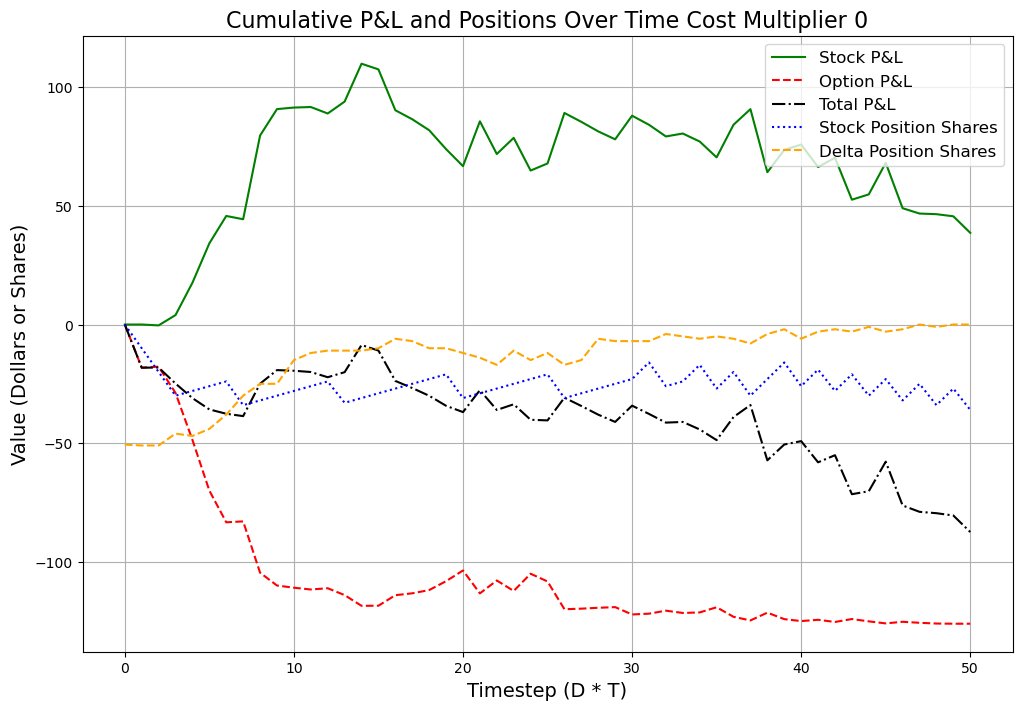

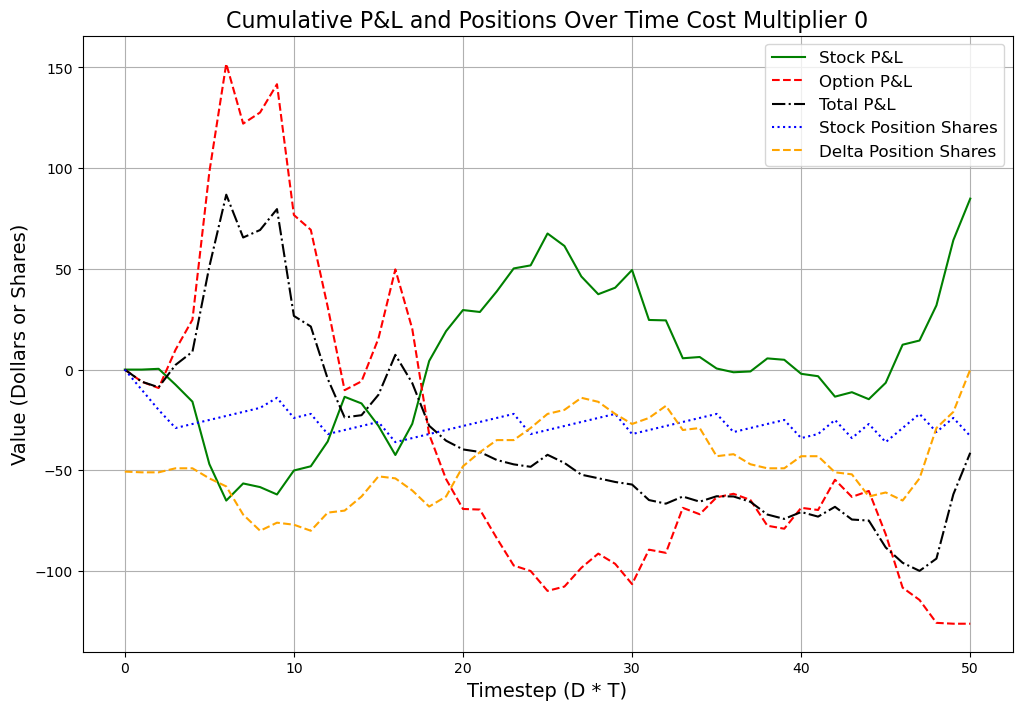

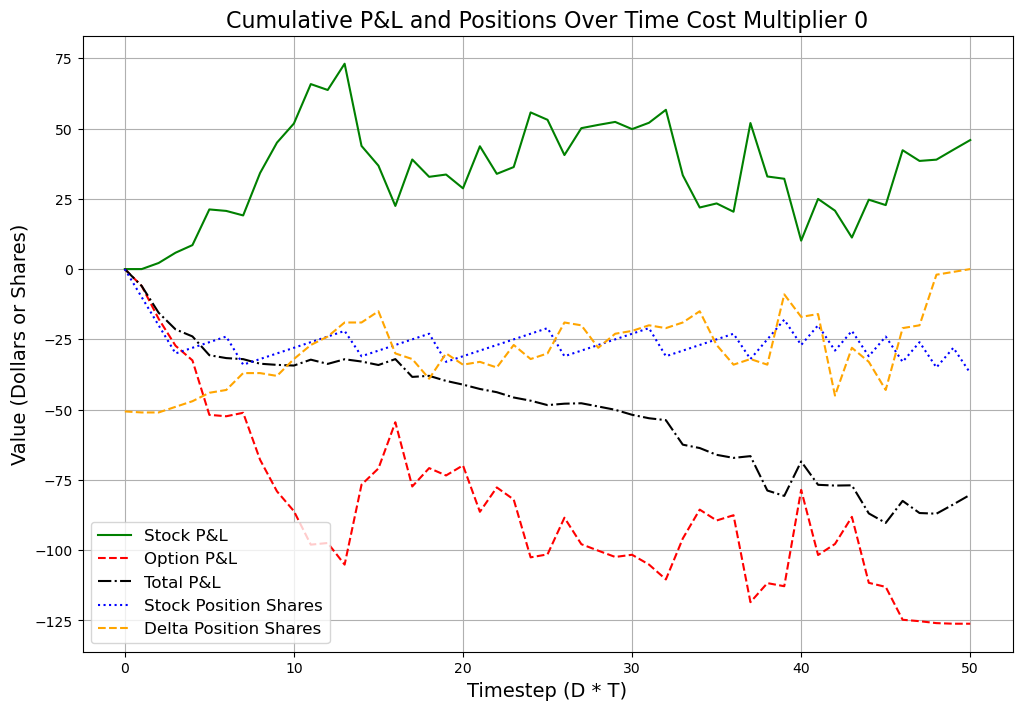

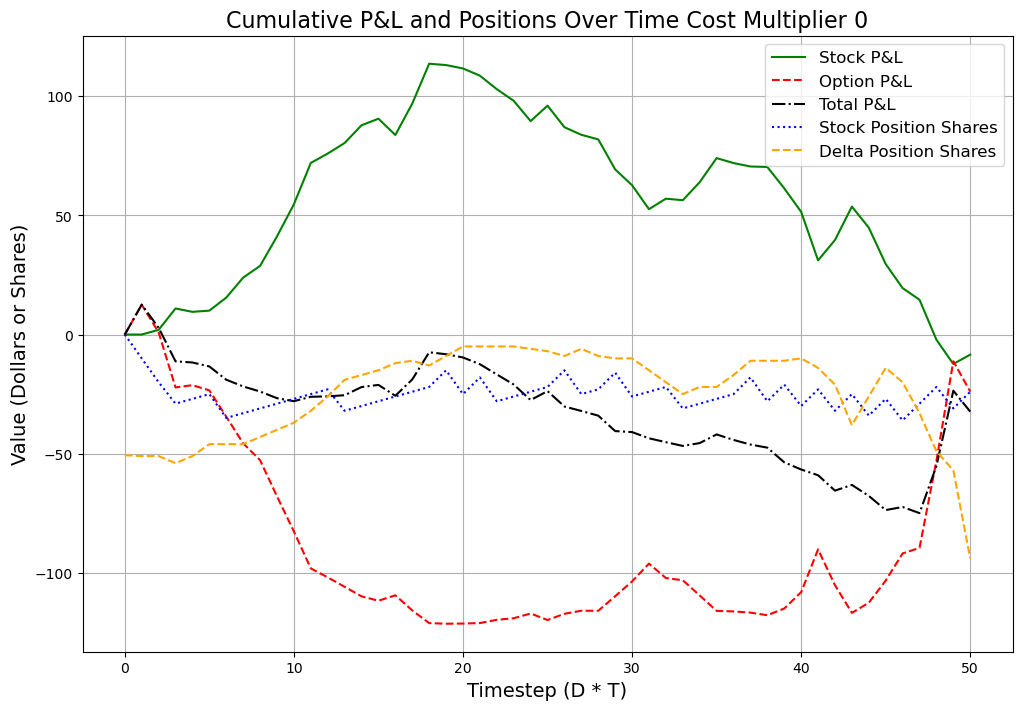

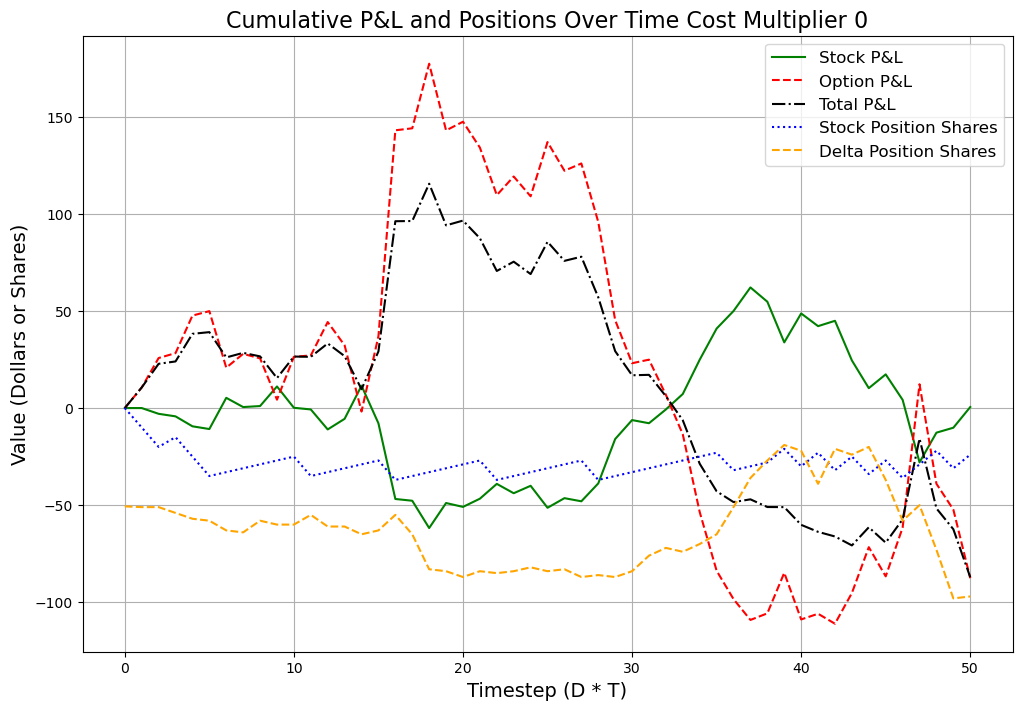

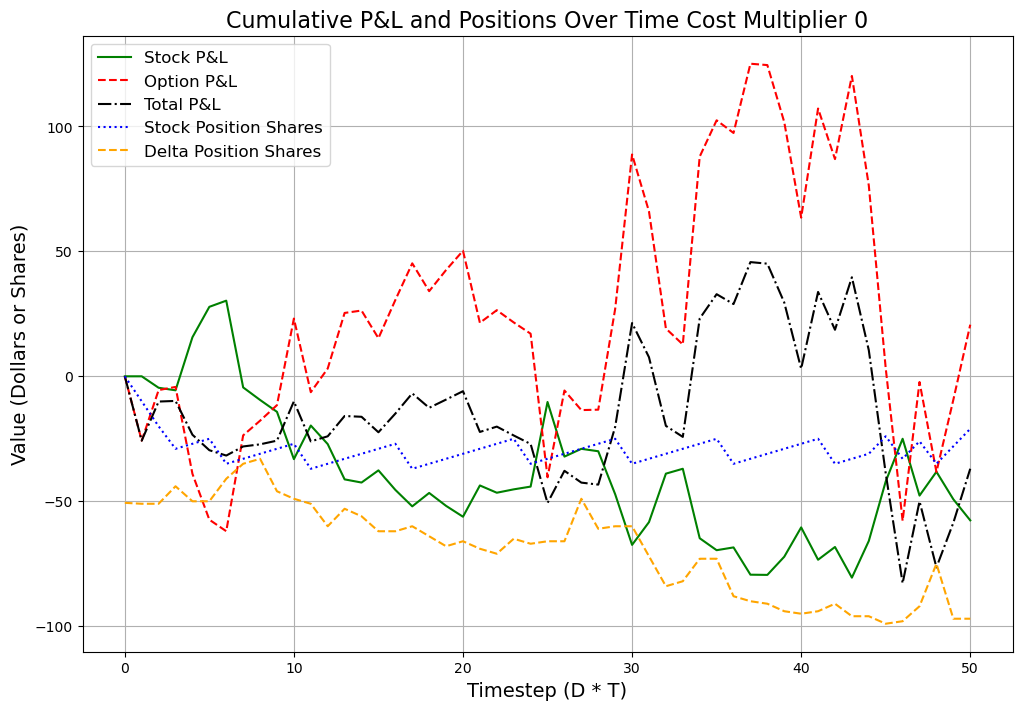

In [26]:
num_episodes = 10

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    cum_option_pnl = 0
    cum_stock_pnl = 0
    cum_cost_pnl = 0
    option_pnls = [0]
    stock_pnls = [0]
    cost_pnls = [0]
    total_pnl = [0]
    stock_pos_shares =[0]
    delta_pos_shares = [-100*env.delta]

    
    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_value = env.get_state()
        current_delta = env.delta
        delta_action =  -100*round(current_delta, 2)
        action, state = model.predict(env.get_state(), deterministic = True)
        next_state, reward, done,done,  info = env.step(action)
        next_holdings, next_asset_price, next_ttm, next_option_value = next_state
        next_delta = env.delta
        delta_h =   next_holdings - current_holdings
        option_pnl = 100*(next_option_value-current_option_value)
        stock_pnl = current_holdings*(next_asset_price -current_asset_price)
        trade_cost = cost(delta_h, 0)
        cum_option_pnl += option_pnl
        cum_stock_pnl += stock_pnl
        cum_cost_pnl += trade_cost

        option_pnls.append(cum_option_pnl)
        stock_pnls.append(cum_stock_pnl)
        cost_pnls.append(cum_cost_pnl)
        total_pnl.append(cum_option_pnl+cum_stock_pnl-cum_cost_pnl)
        stock_pos_shares.append(next_holdings)
        delta_pos_shares.append(delta_action)

        if done:
            state = env.reset()

    time_axis = np.linspace(0, num_steps, num_steps + 1)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, stock_pnls, label='Stock P&L', color='green', linestyle='-')
    plt.plot(time_axis, option_pnls, label='Option P&L', color='red', linestyle='--')
    #plt.plot(time_axis, cost_pnls, label='Cost P&L', color='magenta', linestyle='--')
    plt.plot(time_axis, total_pnl, label='Total P&L', color='black', linestyle='-.')
    plt.plot(time_axis, stock_pos_shares, label='Stock Position Shares', color='blue', linestyle=':')
    plt.plot(time_axis, delta_pos_shares, label='Delta Position Shares', color='orange', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Timestep (D * T)', fontsize=14)
    plt.ylabel('Value (Dollars or Shares)', fontsize=14)
    plt.title('Cumulative P&L and Positions Over Time Cost Multiplier 0', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.savefig("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/results/PPO/du/plots/PPO_19/OOS_Path_Cost5")
    plt.show()

In [ ]:
import pandas as pd 
def student_t_statistic(data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    t_statistic = sample_mean / (sample_std / np.sqrt(n))
    return t_statistic

# Getting kernel density estimates for cost and volatility
num_episodes = 1000
cost_pnls_dh = []
cost_pnls_ppo = []
total_pnls_vol_dh = []
total_pnls_vol_ppo = []
t_stat_pnls_dh = []
t_stat_pnls_ppo = []

for episode in range(num_episodes): 
    state = env.reset(seed =2024)
    done = False
    samp_cost_pnl_dh = 0
    samp_cost_pnl_ppo = 0

    pnl_diffs_ppo = []
    pnl_diffs_dh = []
    
    previous_pnl_ppo = 0
    previous_pnl_dh = 0
    
    total_pnl_ppo = 0
    total_pnl_dh = 0
    samp_total_pnl_dh = []
    samp_total_pnl_ppo = []

    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_value, current_delta= env.get_state()

        action, _states = model.predict(env.get_state(), deterministic=True)
        next_state, reward, done,done,  info = env.step(action)
        next_holdings, next_asset_price, next_ttm, next_option_value, next_delta = next_state
        
        delta_h_ppo = -next_holdings- (-current_holdings)
        delta_h_dh = (-round(next_delta, 2)) - (-round(current_delta, 2))


        # Cost calculations for both policies
        samp_cost_pnl_dh += cost(delta_h_dh, 5)
        samp_cost_pnl_ppo += cost(delta_h_ppo, 5)

        # P&L differences between steps
        pnl_ppo = ((next_option_value - current_option_value) - current_holdings * (next_asset_price - current_asset_price) - cost(delta_h_ppo, 5))
        pnl_dh = ((next_option_value - current_option_value) + (-round(current_delta, 2)) * (next_asset_price - current_asset_price) - cost(delta_h_dh, 5))
        
        pnl_diffs_ppo.append(pnl_ppo - previous_pnl_ppo)
        pnl_diffs_dh.append(pnl_dh - previous_pnl_dh)

        # Update previous P&L
        previous_pnl_ppo = pnl_ppo
        previous_pnl_dh = pnl_dh

        # Accumulate the cumulative P&L for each policy
        total_pnl_ppo+= pnl_ppo
        total_pnl_dh += pnl_dh
        samp_total_pnl_ppo.append(total_pnl_ppo)
        samp_total_pnl_dh.append(total_pnl_dh)



        if done:
            # Volatility is the standard deviation of P&L differences
            vol_ppo = np.std(pnl_diffs_ppo)
            vol_dh = np.std(pnl_diffs_dh)

            # Calculate student t-statistic based on cumulative P&L at the end of the episode
            t_stat_pnl_ppo = student_t_statistic(samp_total_pnl_ppo)  # Use cumulative P&L
            t_stat_pnl_dh = student_t_statistic(samp_total_pnl_dh)  # Use cumulative P&L

            # Append cost and volatility for this episode
            cost_pnls_ppo.append(samp_cost_pnl_ppo)
            cost_pnls_dh.append(samp_cost_pnl_dh)
            total_pnls_vol_ppo.append(vol_ppo)
            total_pnls_vol_dh.append(vol_dh)
            t_stat_pnls_ppo.append(t_stat_pnl_ppo)
            t_stat_pnls_dh.append(t_stat_pnl_dh)

            state = env.reset()



df = pd.DataFrame({
    "cost_pnls_ppo" : cost_pnls_ppo,
    "cost_pnls_dh" : cost_pnls_dh,
    "total_pnls_vol_ppo" : total_pnls_vol_ppo,
    "total_pnls_vol_dh" : total_pnls_vol_dh,
    "t_stat_pnls_ppo" : t_stat_pnls_ppo,
    "t_stat_pnls_dh" : t_stat_pnls_dh

})

df.to_csv('density_data.csv', index=False)

# Plotting the KDE and results
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Plot kernel density estimates for total cost
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(cost_pnls_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot( total_pnls_vol_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(total_pnls_vol_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Cumulative P&L
plt.subplot(1, 3, 3)
sns.kdeplot(t_stat_pnls_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(t_stat_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title("Student's t-Statistic KDE for Cumulative P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd 

df = pd.read_csv("C:/Users/levyb\Documents/Masters Data Science - 2nd Year/deepHedgingRL/results/PPO/du/density_data.csv")
df

In [383]:
cost_pnls_ppo = df["cost_pnls_ppo"].tolist()
cost_pnls_dh = df["cost_pnls_dh"].tolist()
total_pnls_vol_ppo = df["total_pnls_vol_ppo"].tolist()
total_pnls_vol_dh= df["total_pnls_vol_dh"].tolist()
t_stat_pnls_ppo = df["t_stat_pnls_ppo"].tolist()
t_stat_pnls_dh= df["t_stat_pnls_dh"].tolist()


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot([x for x in cost_pnls_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x for x in cost_pnls_dh], label='Policy: $\delta_{DH}$', shade =True, color = "orange")
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot([x for x in total_pnls_vol_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x for x in total_pnls_vol_dh], label='Policy: $\delta_{DH}$', shade=True, color = "orange")
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Cumulative P&L
plt.subplot(1, 3, 3)
sns.kdeplot( [x/5 for x in t_stat_pnls_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x/5 for x in t_stat_pnls_dh], label='Policy: $\delta_{DH}$', shade=True, color = "orange")
plt.title("Student's t-Statistic KDE for Cumulative P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/results/PPO/du/plots/PPO_19/KDE_PPO")
plt.show()


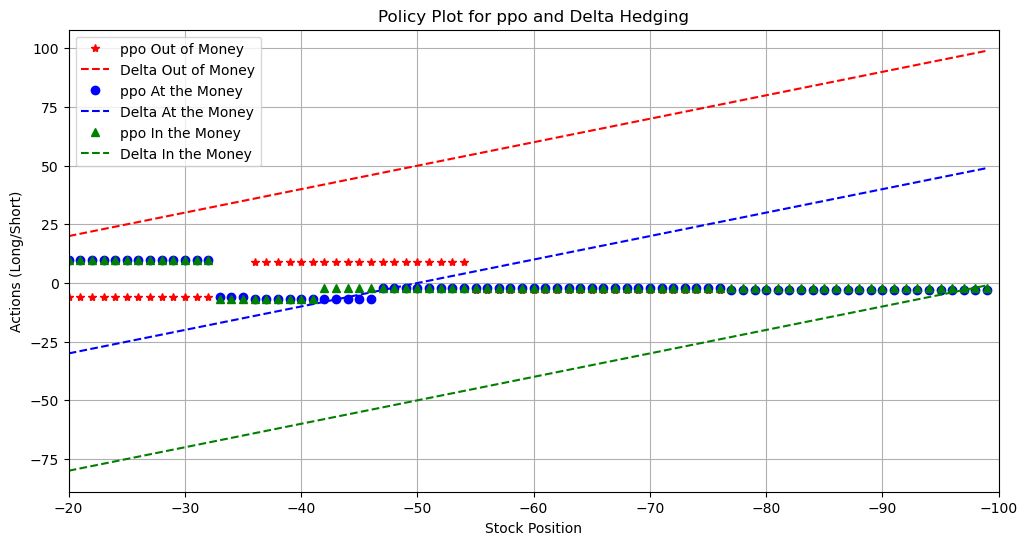

In [27]:
# Define parameters for the BSM model
delta_mapping = np.arange(-10, 11)
strike_price = 100
env.reset()
# Define stock prices for out-of-the-money, at-the-money, and in-the-money scenarios
stock_prices = [98, 100, 102] 
time_to_maturity = 1/5

# Initialize arrays to store actions
ppo_actions_out_of_money = []
ppo_actions_at_money = []
ppo_actions_in_money = []


stock_positions = np.arange(-20, -100, -1)  # Adjust as necessary
deltas_out= np.arange(0.20,1, 0.01)
deltas_at = np.arange(-0.30, 0.50, 0.01)
deltas_in = np.arange(-0.80,0, 0.01)



for i in range(len(stock_positions)):
    # Time to maturity remains constant for this plot
    ttm = time_to_maturity  # Time to maturity in years

    # Out-of-the-money (S = 98)
    S_out = 98
    # Compute option price and delta
    option_price_out = opm.compute_option_price(ttm, S_out, mode='ttm')
    env.set_state(stock_positions[i], S_out, ttm, option_price_out, deltas_out[i])
    action_out, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_out_of_money.append(delta_mapping[action_out])

    # At-the-money (S = 100)
    S_at = 100
    option_price_at = opm.compute_option_price(ttm, S_at, mode='ttm')
    env.set_state(stock_positions[i], S_at, ttm, option_price_at,deltas_at[i])
    action_at, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_at_money.append(delta_mapping[action_at])


    # In-the-money (S = 102)
    S_in = 102
    option_price_in = opm.compute_option_price(ttm, S_in, mode='ttm')
    env.set_state(stock_positions[i], S_in, ttm, option_price_in, deltas_in[i])
    action_in, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_in_money.append(delta_mapping[action_in])

# Plotting
plt.figure(figsize=(12, 6))

# Out-of-the-money
plt.plot(stock_positions, ppo_actions_out_of_money, label="ppo Out of Money", marker="*", linestyle="", color= "red")
plt.plot(stock_positions, [x*100 for x in deltas_out], label="Delta Out of Money", linestyle="--",color= "red")

# At-the-money
plt.plot(stock_positions, ppo_actions_at_money, label="ppo At the Money", marker="o", linestyle="", color = "blue")
plt.plot(stock_positions, [x*100 for x in deltas_at], label="Delta At the Money", linestyle="--", color = "blue")

# In-the-money
plt.plot(stock_positions, ppo_actions_in_money, label="ppo In the Money", marker="^", linestyle="", color ="green")
plt.plot(stock_positions, [x*100 for x in deltas_in], label="Delta In the Money", linestyle="--", color = "green")

plt.xlim(-20, -100)
plt.title("Policy Plot for ppo and Delta Hedging")
plt.xlabel("Stock Position")
plt.ylabel("Actions (Long/Short)")
plt.legend()
plt.grid(True)
plt.savefig("PPO Policy Plot")
plt.show()
